In [1]:
!pip3 install pymc3==3.9.3
!pip3 install arviz==0.11.0
!pip3 install pymc
!pip3 install statsmodels

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import arviz as az
from statsmodels.tsa import stattools
import statsmodels.api as sm
import pymc3 as pm
import pymc

import os
import sys
from plot_lib import set_default

set_default(figsize=(6, 4))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Read dataset - Infant mortality
cookies = pd.read_csv('data/cookies.dat', sep='\s', engine='python') 
# Checking dataframe
print("The shape of the dataset is: {}".format(cookies.shape))
cookies.head()

The shape of the dataset is: (150, 2)


,"""chips""","""location"""
0,12,1
1,12,1
2,6,1
3,13,1
4,12,1


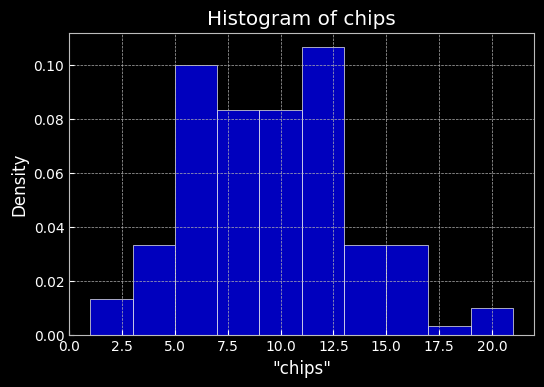

In [4]:
# Plotting the histogram of chips
fig, ax = plt.subplots(1, 1)
sns.histplot(cookies['"chips"'], stat= 'density', bins = 10)
plt.title('Histogram of chips')
plt.show()

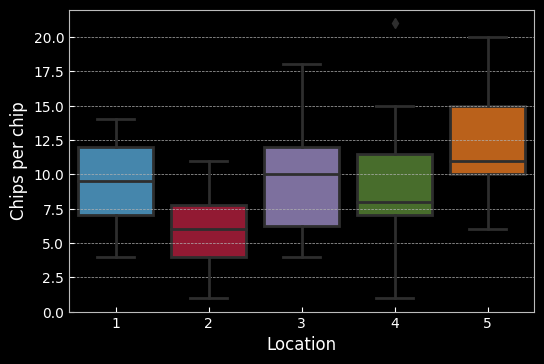

In [5]:
sns.boxplot(x=cookies['"location"'], y = cookies['"chips"'])
plt.xlabel('Location')
plt.ylabel('Chips per chip')
plt.show()

This shows us the distribution of the number of chips by different locations. It looks like maybe location five tends to be more generous on average than the others. 

Let's remind ourselves what this model looks like. We have the $i^{th}$ cookie from the $j^{th}$ location and $y_{ij}$ represents the number of chocolate chips in that cookie. Where $\lambda_j$ is the average or mean number of chips per cookie for location $j$. 

The different location means come from this gamma distribution with these hyper parameters. Before implementing the model, we need to select prior distributions for both $\alpha$ and $\beta$. First, think about what the lambdas represent. 

In location $j$ $\lambda_j$ is the expected number of chocolate chips per cookie. $\alpha$ and $\beta$ control the distribution for these means between locations. The mean of this gamma distribution will  represent the overall mean of number of chips for all cookies. The variance of this gamma distribution controls the variability between locations in the mean number of chips. If this variance is high, the mean number of chips will vary widely from location to location. If it is small, the mean number of chips will be nearly the same from location to location. 

This can be seen below:

$y_{i,j} | \lambda_j \stackrel{ind}{\sim} Poisson(\lambda_j), i = 1,...,30, j = 1,..,5$

$ \lambda_i | \alpha, \beta \stackrel{ind}{\sim} \text{Gamma}(\alpha, \beta), j = 1, ... , 5$

$ \alpha = \frac{\mu^2}{\sigma^2}$

$ \beta = \frac{\mu}{\sigma^2}$

$ \mu \sim Gamma(2, 1/5)$

$ \sigma \sim Exp(1) $

### Prior predictive checks

To see the effects of different priors on the distribution of $λ$, we can simulate. Suppose we try independent exponential priors for $α$ and $β$.

In [6]:
from scipy.stats import expon

np.random.seed(112)
n_sim = 500 # Draw 500 samples
alpha_pri = expon.rvs(size=n_sim, scale = 1 / 0.5) # Exponential prior for alpha with lamb = 1 / scale
beta_pri = expon.rvs(size=n_sim, scale = 1 / 5) # Exponential prior for beta with lamb = 1 / scale
mu_pri = alpha_pri / beta_pri # Mean
sig_pri = np.sqrt(alpha_pri / beta_pri**2) # Stdv

# Describe for mu
print(pd.DataFrame(mu_pri).describe())
print('The meddian is: {}'.format(np.median(mu_pri)))

                 0
count   500.000000
mean     69.729890
std     411.026966
min       0.016805
25%       3.356654
50%       9.851695
75%      32.233714
max    7872.473752
The meddian is: 9.85169500347186


In [7]:
# Describe for sigma
print(pd.DataFrame(sig_pri).describe())
print('The meddian is: {}'.format(np.median(sig_pri)))

                 0
count   500.000000
mean     50.154882
std     350.827310
min       0.283655
25%       3.763907
50%       7.826139
75%      23.253997
max    7132.433397
The meddian is: 7.826138550708875


The last information is the summary of our prior for the mean and stdv of the gamma distribution.

After simulating from the priors for $α$ and $β$, we can use those samples to simulate further down the hierarchy:

In [8]:
from scipy.stats import gamma

# Draw from gamma
lam_pri = gamma.rvs(a = alpha_pri, scale = 1 / beta_pri, size=n_sim)

# Describe lambda
print(pd.DataFrame(lam_pri).describe())
print('The meddian is: {}'.format(np.median(lam_pri)))

                  0
count  5.000000e+02
mean   6.842191e+01
std    4.453380e+02
min    9.528325e-80
25%    1.121539e+00
50%    7.515131e+00
75%    2.926047e+01
max    7.890503e+03
The meddian is: 7.515130932318256


If we want to see what kind of responses this prior model would produce, we can simulate even further down the chain. We now have Monte Carlo samples for $\alpha$ and $\beta$ and $\lambda$. So we could also  enerate samples from the observed number of chocolate chips. We'll call that $y_{prior}$. This will come from the likelihood Poisson. 

In [9]:
from scipy.stats import poisson

# Draw from poisson
y_prior = poisson.rvs(mu = lam_pri, size=n_sim)

# Describe lambda
print(pd.DataFrame(y_prior).describe())
print('The meddian is: {}'.format(np.median(y_prior)))

                 0
count   500.000000
mean     68.964000
std     450.369386
min       0.000000
25%       1.000000
50%       7.000000
75%      30.000000
max    7999.000000
The meddian is: 7.0


If we wanted to create a prior predictive reconstruction of our original data set, say for five locations. We would keep only five of these $\lambda$ draws. We'll reassign $\lambda$ prior to the $\lambda$ prior for the first five values. 

In [10]:
# Draw from gamma
lam_pri = gamma.rvs(a = alpha_pri[:5], scale = 1 / beta_pri[:5], size = 5)
print('The five gammas are: {}'.format(lam_pri))
# Draw from poisson
y_prior = poisson.rvs(mu = np.repeat(lam_pri, 30).shape, size = 155)
print('The five y_i are: {}'.format(y_prior[:5]))

The five gammas are: [3.40618484e+01 2.98261311e+02 2.95113601e+01 2.30916628e-01
 9.23068993e+00]
The five y_i are: [145 150 153 147 164]


Because these priors have high variance and are somewhat noninformative, they produce unrealistic predictive distributions. Still, enough data would overwhelm the prior, resulting in useful posterior distributions. Alternatively, we could tweak and simulate from these prior distributions until they adequately represent our prior beliefs. Yet another approach would be to re-parameterize the gamma prior.

In [11]:
### Formatting data as numpy instead of DF
Y = cookies.pop('"chips"').to_numpy()
X = cookies.to_numpy()

In [12]:
### Defining the model

# Set number of storage for cookies
storages = X.max()

with pm.Model() as lr:
    ###  Definen priors of parameters

    # Fourth level of parameters
    mu = pm.Gamma('mu', alpha = 2.0, beta = 1.0 / 5.0) # Mu parameter from gamma
    sig = pm.Exponential('sigma', lam = 1.0) # sig parameter from exponential > 0

    # Parameters for Gamma
    alpha = mu**2 / sig**2
    beta = mu / sig**2

    # Second level of parameters 
    # Shape equals five as there is five lambdas, one per each storage
    lam = pm.Gamma('lambda', alpha = alpha, beta = beta, shape = storages)
    
    x_ = pm.Data('features', X.ravel()) # Data container, can be changed

    final_lam = lam[x_ - 1]

    # Likelihood
    obs = pm.Poisson('likelihood', mu = final_lam, observed = Y)

In [13]:
with lr:
    # Use MCMC to sample 10000 samples
    trace = pm.sample(5000, tune = 1000, cores=4, init='adapt_diag')
    # Tune gives a number of samples to reject. These are used to calibrate the sampler. 
    # After the number of samples in tune, the following are considered useful.

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda, sigma, mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 37 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


### MCMC convergence diagnostic

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


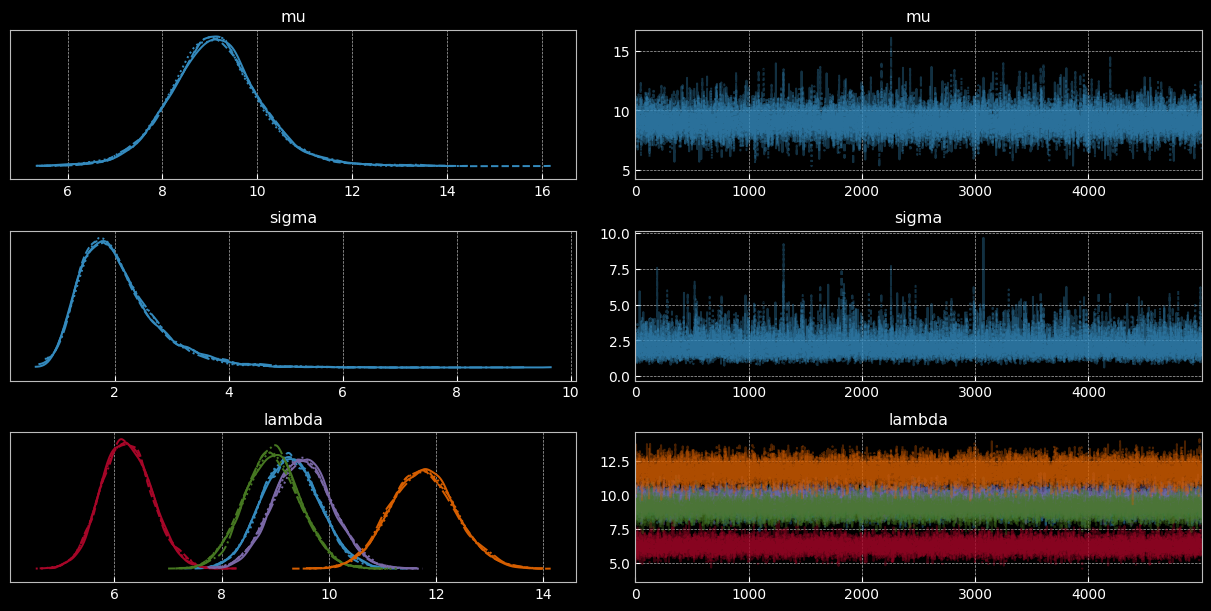

In [14]:
# Plotting posterior distributions
az.plot_trace(trace)
plt.show()

In [15]:
pm.summary(trace)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,9.104,0.977,7.206,10.903,0.008,0.006,14522.0,14192.0,15144.0,11727.0,1.0
sigma,2.071,0.711,0.984,3.406,0.006,0.004,13310.0,12829.0,13740.0,11874.0,1.0
lambda[0],9.290,0.539,8.289,10.305,0.004,0.003,19876.0,19855.0,19859.0,14813.0,1.0
lambda[1],6.235,0.468,5.363,7.116,0.004,0.003,16775.0,16449.0,16997.0,12906.0,1.0
lambda[2],9.520,0.548,8.488,10.542,0.004,0.003,19726.0,19726.0,19695.0,15421.0,1.0
lambda[3],8.951,0.523,7.971,9.945,0.004,0.003,18982.0,18982.0,18948.0,13996.0,1.0
lambda[4],11.758,0.612,10.645,12.961,0.004,0.003,20301.0,20301.0,20221.0,14500.0,1.0


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


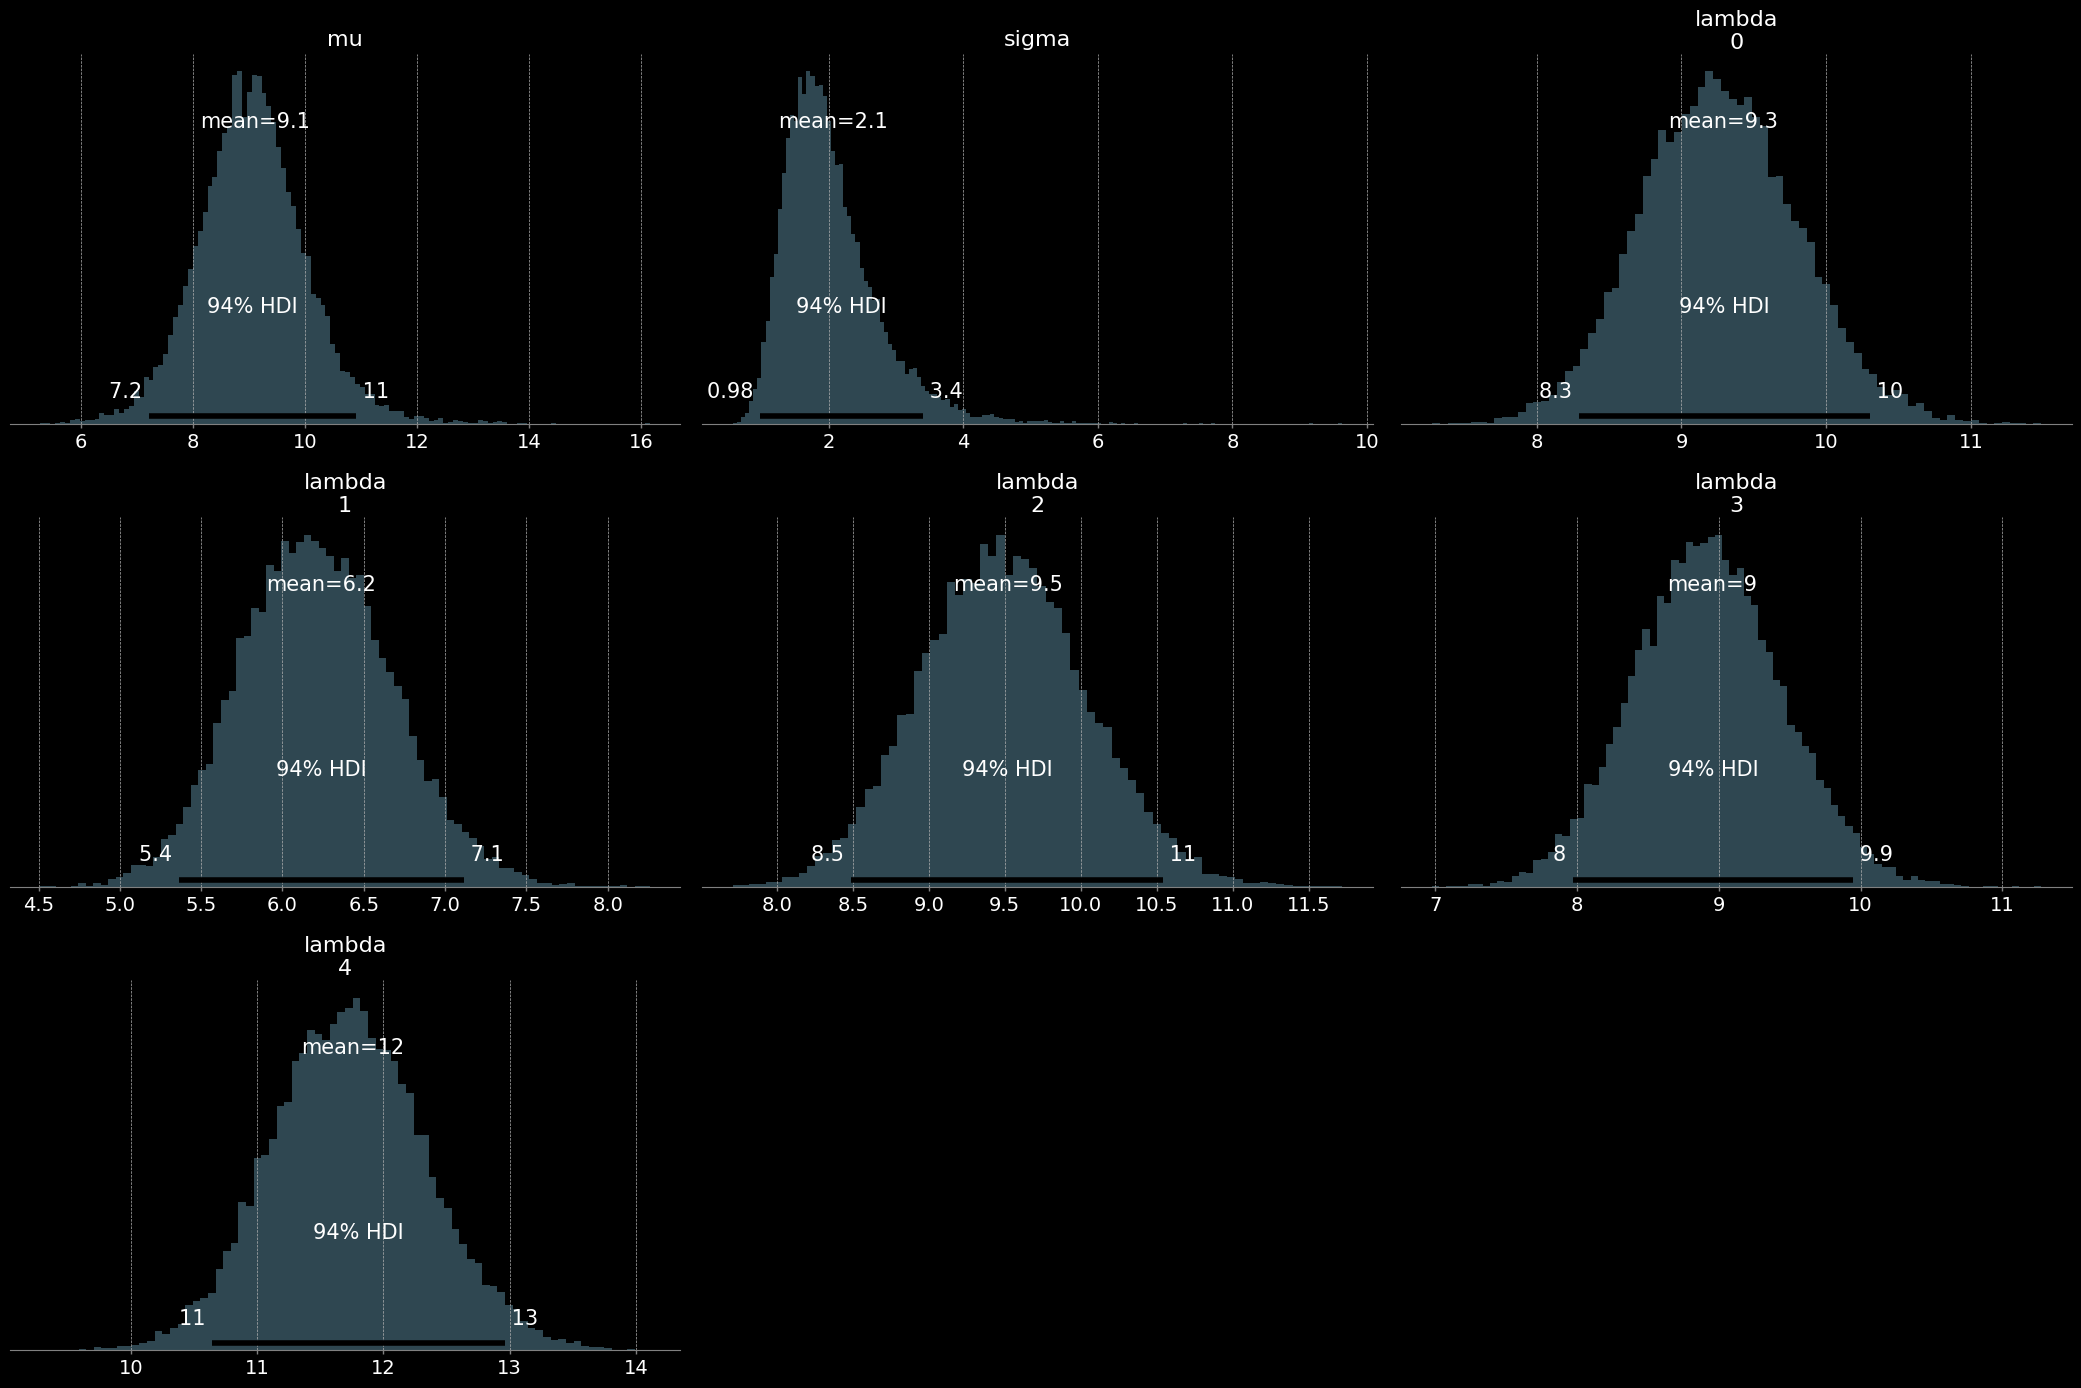

In [16]:
az.plot_posterior(trace, point_estimate = 'mean', kind = 'hist', color= "#87ceeb")
plt.show()

### Residuals

After assessing convergence, we can check the fit via residuals. With a hierarhcical model, there are now two levels of residuals: the observation level and the location mean level. To simplify, we’ll look at the residuals associated with the posterior means of the parameters.

In [17]:
with lr:
    pm.set_data({'features': X.ravel()})
    posterior = pm.sample_posterior_predictive(trace)

y_pred = posterior['likelihood']
print('The shape of the observations is: {}'.format(y_pred.shape))

The shape of the observations is: (20000, 150)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


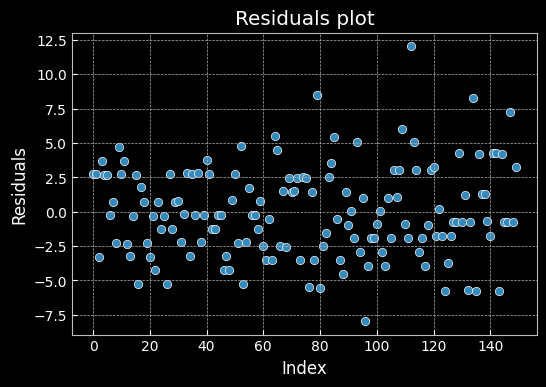

In [18]:
# Plotting the predictions
y_hat = np.mean(y_pred, axis=0).ravel()
y_std = y_pred.std(axis=0).ravel()
res = Y - y_hat

# Plotting residuals
sns.scatterplot(np.arange(res.shape[0]), res, x="Index", y="Residuals")
plt.title('Residuals plot')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.show()

These residuals look pretty good, they do not show any patterns against the index. 

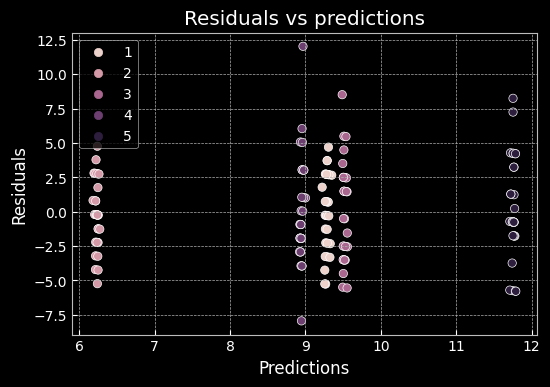

In [19]:
# Plotting predictions vs residuals
sns.scatterplot(x = y_hat, y = res, hue = X.ravel()[:])
plt.title('Residuals vs predictions')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

This plot also looks good! We do see an increase in the variance in the residuals possibly. But that is to be expected because this is a Poisson likelihood where the variance increases as the mean increases. 

Another way we can check that is to look a the variance of the residuals in the left group. So this is the residuals where $\hat{y}$ is less than 7. The predicted values are close to 6 so they should have variance close to 6. 

In [20]:
first_group = res[y_hat[:] < 7]

print('The variance of the first group is: {}'.format(np.var(first_group)))

# Similar for right-most group

fifth_group = res[y_hat[:] > 11]

print('The variance of the fifth group is: {}'.format(np.var(fifth_group)))

The variance of the first group is: 6.249098013058333
The variance of the fifth group is: 13.266917549191668


### Checking residuals of papameters

we can look at how the location means differ from the overall mean $μ$.

In [21]:
with lr:
    pm.set_data({'features': X.ravel()})
    posterior_params = pm.sample_posterior_predictive(trace, var_names=["lambda", "mu"])

In [22]:
mean_lambdas = np.mean(posterior_params['lambda'], axis=0).ravel()
mean_mu = np.mean(posterior_params['mu'], axis=0).ravel()

print('The mean value of lambdas is: {}'.format(mean_lambdas))
print('The mean value of mu is: {}'.format(mean_mu))

The mean value of lambdas is: [ 9.29033188  6.23450263  9.52049278  8.95090494 11.75805163]
The mean value of mu is: [9.10377009]


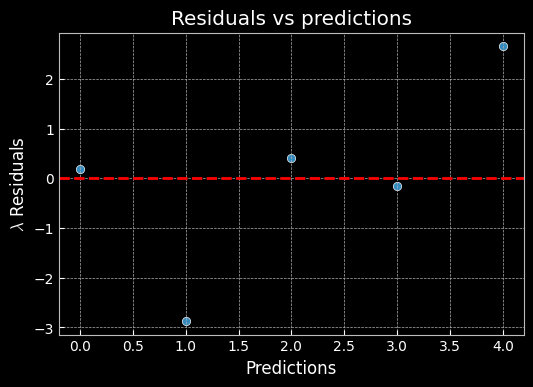

In [23]:
# Plotting predictions vs residuals
sns.scatterplot(x = np.arange(len(mean_lambdas)), y = mean_lambdas - mean_mu)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs predictions')
plt.xlabel('Predictions')
plt.ylabel('$\lambda$ Residuals')
plt.show()

We don’t see any obvious violations of our model assumptions.

### Posterior predictive simulation

Just as we did with the prior distribution, we can use these posterior samples to get Monte Carlo estimates that interest us from the posterior predictive distribution.

For example, we can use draws from the posterior distribution of $μ$ and $σ$ to simulate the posterior predictive distribution of the mean for a new location.

In [24]:
# Sampling mu and sig
with lr:
    pm.set_data({'features': X.ravel()})
    posterior_params = pm.sample_posterior_predictive(trace, var_names=["mu", "sigma"])

In [25]:
mean_mu = np.mean(posterior_params['mu'], axis=0).ravel()
mean_sigma = np.mean(posterior_params['sigma'], axis=0).ravel()

print('The mean value of mu is: {}'.format(mean_mu))
print('The mean value of sigma is: {}'.format(mean_sigma))

The mean value of mu is: [9.10377009]
The mean value of sigma is: [2.07146623]


The value of Alpha is: [19.31465019]
The value of Beta is: [2.12161006]


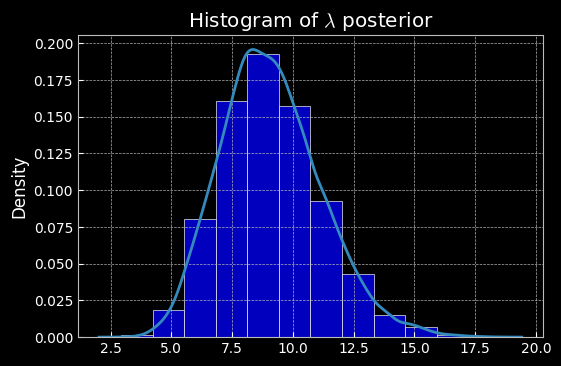

In [26]:
# Parameters for Gamma
alpha = mean_mu**2 / mean_sigma**2
beta = mean_mu / mean_sigma**2

print('The value of Alpha is: {}'.format(alpha))
print('The value of Beta is: {}'.format(beta))

# Draw from gamma
n_sim = 15000
post_lamb = gamma.rvs(a = alpha, scale = 1 / beta, size=n_sim)

# Plotting the histogram of chips
fig, ax = plt.subplots(1, 1)
sns.histplot(post_lamb, stat= 'density', bins = 12)
sns.kdeplot(post_lamb, bw_adjust = 1.0, label = 'Density estimate posterior $\lambda_1$')
plt.title('Histogram of $\lambda$ posterior')
plt.show()

We could also compute posterior predictive probabilities like what is the predictive probability that a new location would have a lambda greater than $15$ for example. 

In [27]:
print('The probability that P(lambda >= 15) = {}'.format(np.mean(post_lamb > 15)))

The probability that P(lambda >= 15) = 0.007333333333333333


Using these $λ$ draws, we can go to the observation level and simulate the number of chips per cookie, which takes into account the uncertainty in $λ$:

The meddian is: 149.0


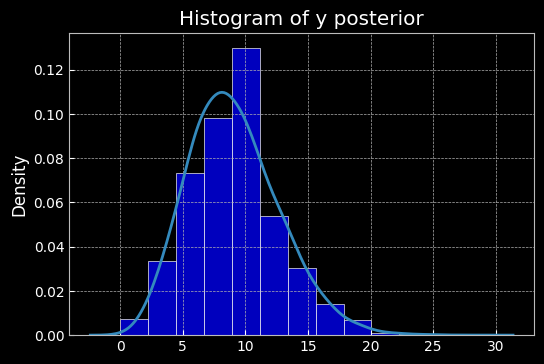

In [28]:
# Drawing from Poisson
y_posterior = poisson.rvs(mu = post_lamb, size=n_sim)

print('The meddian is: {}'.format(np.median(y_prior)))

# Plotting the histogram of chips
fig, ax = plt.subplots(1, 1)
sns.histplot(y_posterior, stat= 'density', bins = 13)
sns.kdeplot(y_posterior, bw_adjust=1.5, label = 'Density estimate posterior $y$')
plt.title('Histogram of y posterior')
plt.show()

This distribution represents our posterior predictive distribution of the number of chocolate chips per cookie from a new location. Which averages over our uncertainty in that new location's lambda parameter. 

So we could say what is the posterior probability that the number of chocolate chips produced from a cookie at a new location would be greater than 15. 

In [29]:
print('The probability that P(cookies >= 15) = {}'.format(np.mean(y_posterior > 15)))

The probability that P(cookies >= 15) = 0.050333333333333334


We can also compare what $y$ at future locations might look like based on the model to the original data. Let's look now at a histogram of the original data that chips. And you can see the distribution is not too different. 

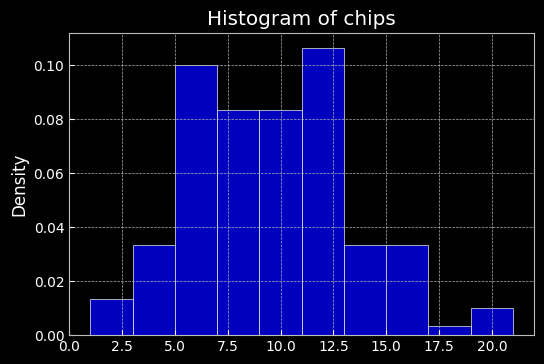

In [30]:
# Plotting the histogram of chips
fig, ax = plt.subplots(1, 1)
sns.histplot(Y, stat= 'density', bins = 10)
plt.title('Histogram of chips')
plt.show()

Finally, we could answer questions like: what is the posterior probability that the next cookie produced in Location 1 will have fewer than seven chips?

In [31]:
# Sampling lambdas
with lr:
    pm.set_data({'features': X.ravel()})
    posterior_params = pm.sample_posterior_predictive(trace, var_names=["lambda"])

Posterior predictive distribution and the number of chips in a future cookie produced at location one. 

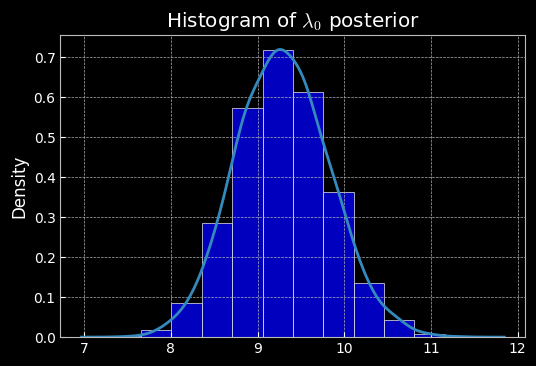

In [32]:
# Plotting the histogram of chips -> lambda 0 or location 1 posterior_params['lambda'][:, 0]
fig, ax = plt.subplots(1, 1)
sns.histplot(posterior_params['lambda'][:, 0], stat= 'density', bins = 12)
sns.kdeplot(posterior_params['lambda'][:, 0], bw_adjust=1.5, label = 'Density estimate posterior $lambda_0$')
plt.title('Histogram of $\lambda_0$ posterior')
plt.show()

We wanted the posterior probability that the next cookie contains less than nice chips. 

In [33]:
print('The probability that P(cookies < 9) = {}'.format(np.mean(posterior_params['lambda'][:, 0] < 9)))

The probability that P(cookies < 9) = 0.30425


We've now seen several advantages, of using Bayesian hierarchical models.

One of those advantages, is that these models allow us to  answer multiple questions with a single model. Not only multiple questions, but multiple kinds of questions about for
example different locations and how we might predict for a new location. Or within an existing location we can make predictions about future chocolate chip cookies. 

These models provide a way to answer these multiple questions through a unified modeling approach that combines all of the data. All of the data for example, in those five locations. 

With Monte Carlo's samples from these hierarchical models, it's easy to estimate posterior probabilities and predictions from these kinds of models. 